# Starbucks Capstone project

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Project Overview :
The goal of this project is to analyze customer behavior on the Starbucks rewards mobile app by combining transactional, demographic, and offer data to determine which demographic groups respond most effectively to different types of offers, and to build a predictive model that enhances offer targeting to maximize customer engagement and revenue.

## Problem Statement

Starbucks aims to optimize its marketing efforts by predicting customer responses to different types of promotional offers (e.g., BOGO, discounts, informational). The company wants to identify which customers are most likely to respond to each type of offer to increase customer engagement and maximize sales.


Importing Libraries

In [288]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



Loading datasets

In [289]:
# Read in the JSON files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration and Preprocessing Summary
- Profile Dataset
    - Exploration: Explored the dataset by inspecting its structure, summary statistics, and distributions of key variables like age and income.
    - Preprocessing: Cleaned the dataset by handling missing values, encoding categorical variables, and removing duplicates.
    - Visualization: Plotted distributions of age and income to understand demographic characteristics.

- Portfolio Dataset
    - Exploration: Examined the dataset to understand the types and attributes of offers, including offer types, difficulty, reward, and duration.
    - Preprocessing: Ensured data integrity and corrected any anomalies.
    - Visualization: Analyzed and visualized the distribution of offer types and their attributes.

- Transcript Dataset
    - Exploration: Investigated the dataset by inspecting records of transactions, offers received, viewed, and completed.
    - Preprocessing: Attempted to merge this dataset with others and resolved key-related issues.
    - Visualization: Visualized event distributions to understand user interactions with offers.


# Profile Dataset

In [290]:
# Display the first few rows of the portfolio dataset
print("Profile dataset:")
print(profile.head())

Profile dataset:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


In [291]:
# Check the basic info and data types
profile.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [292]:
# Get summary statistics for numerical features
profile.describe()


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [293]:
# Check for missing values in the dataset
profile.isnull().sum()


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [294]:
# Fill missing values in 'age' and 'income' columns with median values
profile['age'].fillna(profile['age'].median(), inplace=True)
profile['income'].fillna(profile['income'].median(), inplace=True)


C:\Users\71488\AppData\Local\Temp\ipykernel_22116\2077734081.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  profile['age'].fillna(profile['age'].median(), inplace=True)
C:\Users\71488\AppData\Local\Temp\ipykernel_22116\2077734081.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [295]:
# Standardize gender representation
profile['gender'].replace({'O': 'Other'}, inplace=True)


C:\Users\71488\AppData\Local\Temp\ipykernel_22116\3258073942.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  profile['gender'].replace({'O': 'Other'}, inplace=True)


In [296]:
# Convert 'became_member_on' to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')


# Exploratory Data Analysis 

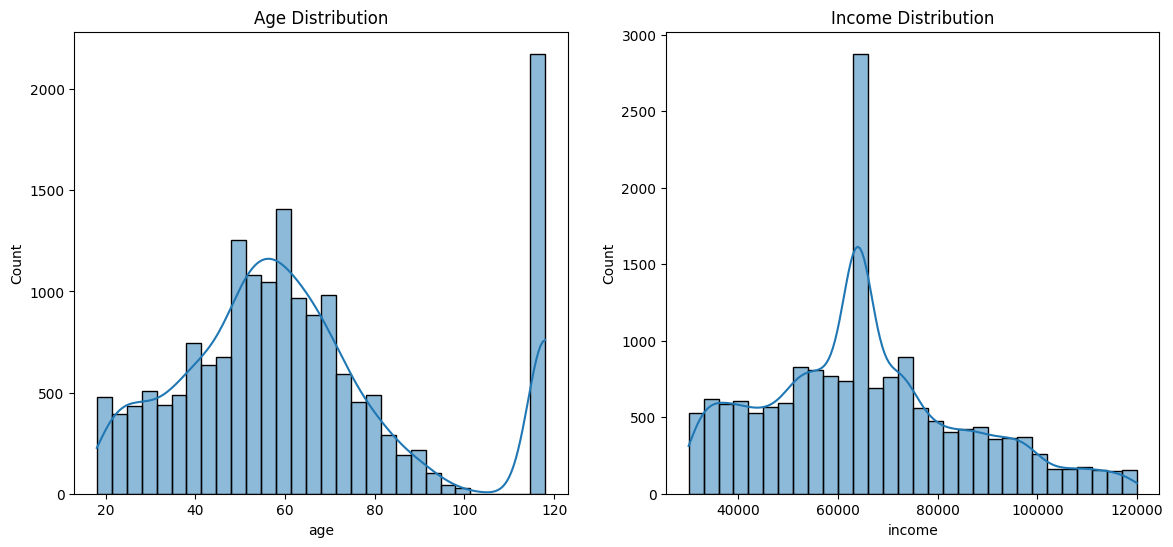

In [297]:
# Plot the distribution of age and income
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(profile['age'], bins=30, kde=True)
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
sns.histplot(profile['income'], bins=30, kde=True)
plt.title('Income Distribution')

plt.show()


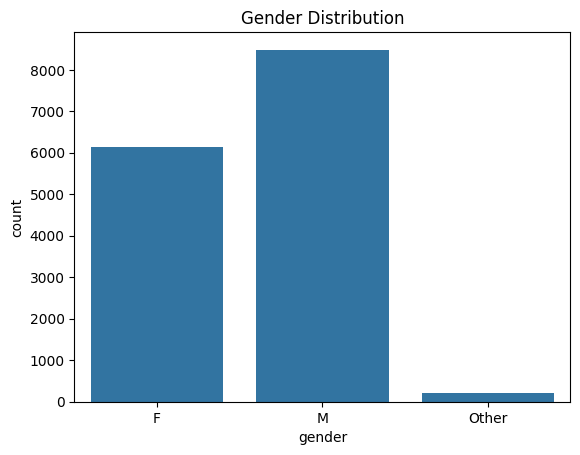

In [298]:
# Plot the distribution of gender
sns.countplot(data=profile, x='gender')
plt.title('Gender Distribution')
plt.show()


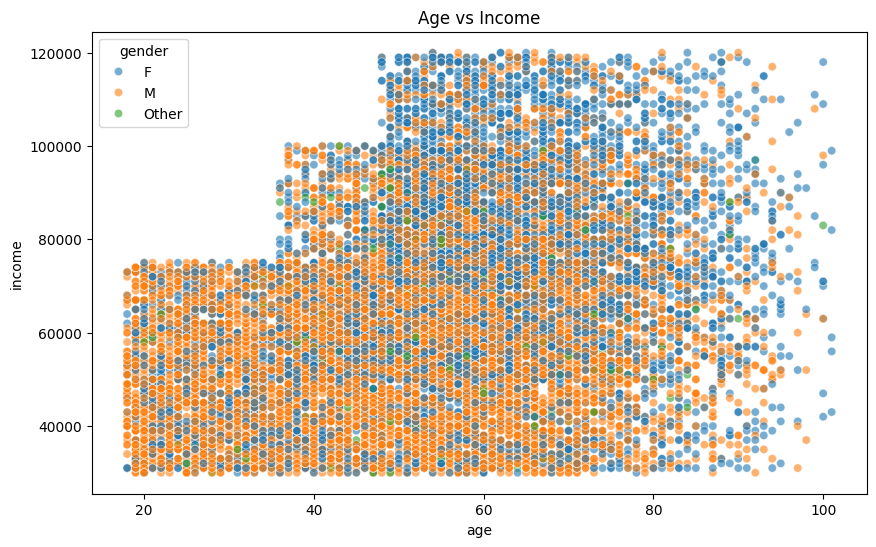

In [299]:
# Scatter plot of age vs income
plt.figure(figsize=(10, 6))
sns.scatterplot(data=profile, x='age', y='income', hue='gender', alpha=0.6)
plt.title('Age vs Income')
plt.show()


In [300]:
# Example: Average income by gender
avg_income_by_gender = profile.groupby('gender')['income'].mean()
print(avg_income_by_gender)


gender
F        71306.412139
M        61194.601603
Other    63287.735849
Name: income, dtype: float64


In [453]:
# Define age groups
bins = [0, 18, 35, 50, 65, 120]  # Defining the bin edges
labels = ['<18', '18-35', '36-50', '51-65', '65+']  # Labels for age groups

# Create age_group column
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)

# Check the distribution of age groups
print(profile['age_group'].value_counts())


age_group
65+      6441
51-65    5150
36-50    3153
18-35    2256
<18         0
Name: count, dtype: int64


In [454]:
# Count of members by age group
count_by_age_group = profile['age_group'].value_counts()
print(count_by_age_group)


age_group
65+      6441
51-65    5150
36-50    3153
18-35    2256
<18         0
Name: count, dtype: int64


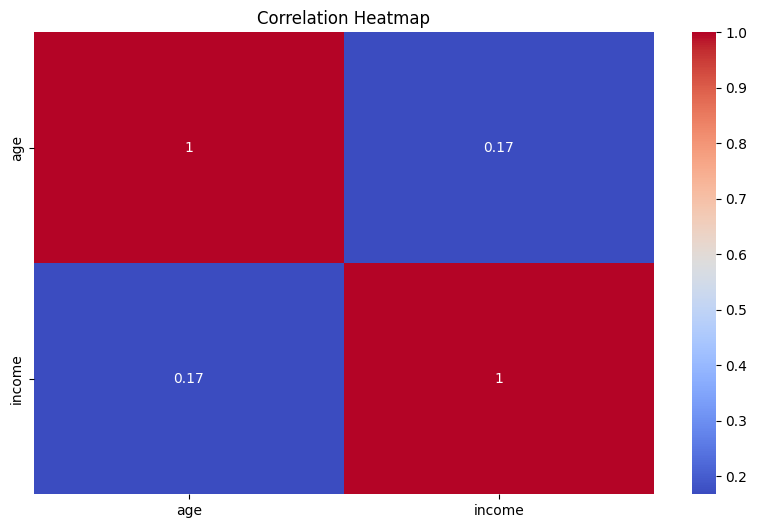

In [455]:
# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(profile[['age', 'income']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Portfolio Dataset

In [456]:
# Display the first few rows of the profile dataset
print("\nProfile dataset:")
print(portfolio.head())


Profile dataset:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  


In [457]:
# Check the basic info and data types
portfolio.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int32 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int32(1), int64(2), object(3)
memory usage: 572.0+ bytes


In [458]:
# Get summary statistics for numerical features
portfolio.describe()


,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [459]:
# Check for missing values in the dataset
portfolio.isnull().sum()


reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [460]:
# Fill missing values in 'difficulty' column with mean value
portfolio['difficulty'].fillna(portfolio['difficulty'].mean(), inplace=True)


C:\Users\71488\AppData\Local\Temp\ipykernel_22116\1136097733.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  portfolio['difficulty'].fillna(portfolio['difficulty'].mean(), inplace=True)


In [461]:
# Verify offer types and validity
print(portfolio['offer_type'].value_counts())


offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64


In [462]:
# Convert 'duration' column to integer type
portfolio['duration'] = portfolio['duration'].astype(int)


# Exploratory Data Analysis 

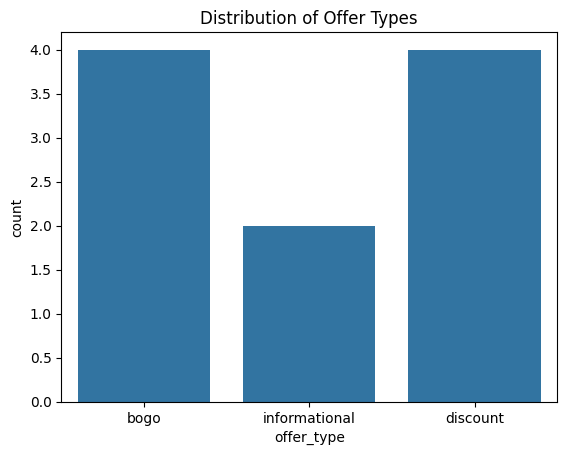

In [463]:
# Plot the distribution of offer types
sns.countplot(data=portfolio, x='offer_type')
plt.title('Distribution of Offer Types')
plt.show()


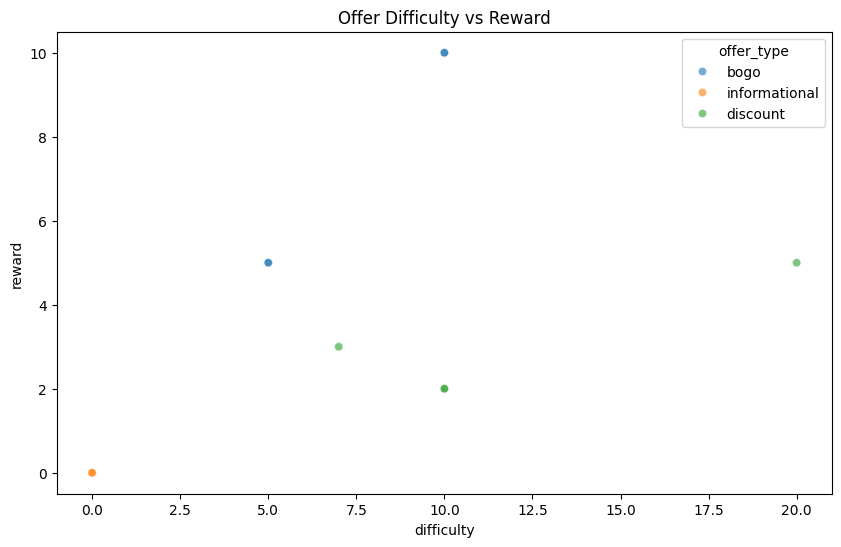

In [464]:
# Scatter plot of offer difficulty vs reward
plt.figure(figsize=(10, 6))
sns.scatterplot(data=portfolio, x='difficulty', y='reward', hue='offer_type', alpha=0.6)
plt.title('Offer Difficulty vs Reward')
plt.show()


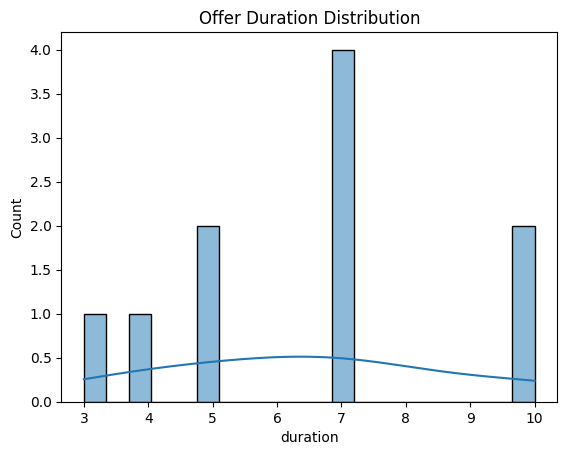

In [465]:
# Plot the distribution of offer durations
sns.histplot(portfolio['duration'], bins=20, kde=True)
plt.title('Offer Duration Distribution')
plt.show()


Display Transcript Dataset

In [466]:
# Display the first few rows of the transcript dataset
print("\nTranscript dataset:")
print(transcript.head())



Transcript dataset:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value       time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'} 1970-01-01   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'} 1970-01-01   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'} 1970-01-01   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'} 1970-01-01   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'} 1970-01-01   

  offer_received_time  
0                 NaT  
1                 NaT  
2                 NaT  
3                 NaT  
4                 NaT  


In [467]:
# Check the basic info and data types
transcript.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               306534 non-null  object        
 1   event                306534 non-null  object        
 2   value                306534 non-null  object        
 3   time                 306534 non-null  datetime64[ns]
 4   offer_received_time  0 non-null       datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 11.7+ MB


In [468]:
# Get summary statistics for numerical features
transcript.describe()


,time,offer_received_time
count,306534,0
mean,1970-01-16 06:22:58.582473722,NaT
min,1970-01-01 00:00:00,NaT
25%,1970-01-08 18:00:00,NaT
50%,1970-01-18 00:00:00,NaT
75%,1970-01-23 00:00:00,NaT
max,1970-01-30 18:00:00,NaT


In [469]:
# Check for missing values in the dataset
transcript.isnull().sum()


person                      0
event                       0
value                       0
time                        0
offer_received_time    306534
dtype: int64

In [470]:
# Fill missing values in 'value' column with empty string
transcript['value'].fillna('', inplace=True)


C:\Users\71488\AppData\Local\Temp\ipykernel_22116\2262641710.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transcript['value'].fillna('', inplace=True)


In [471]:
# Normalize 'event' values to lowercase
transcript['event'] = transcript['event'].str.lower()


In [472]:
# Convert 'time' column to datetime format with hours as unit
transcript['time'] = pd.to_datetime(transcript['time'], unit='h')


In [473]:
# Example of creating derived features: Calculate offer received time
# Note: Adjust based on actual data schema
transcript['offer_received_time'] = pd.to_datetime(transcript['value'].apply(lambda x: x.get('received_time', '')))


# Exploratory Data Analysis 

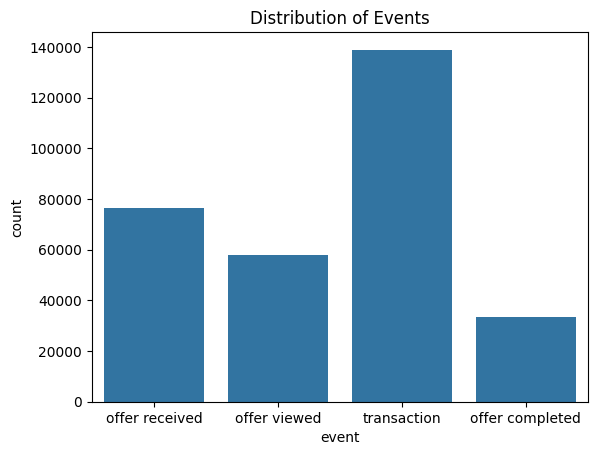

In [474]:
# Plot the distribution of events
sns.countplot(data=transcript, x='event')
plt.title('Distribution of Events')
plt.show()


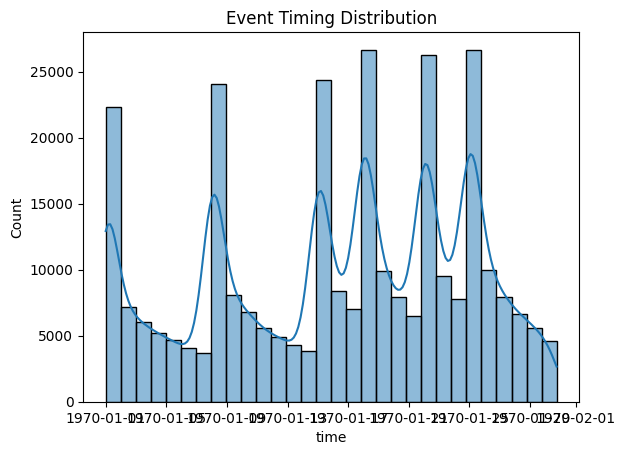

In [475]:
# Plot the distribution of event timings
sns.histplot(transcript['time'], bins=30, kde=True)
plt.title('Event Timing Distribution')
plt.show()


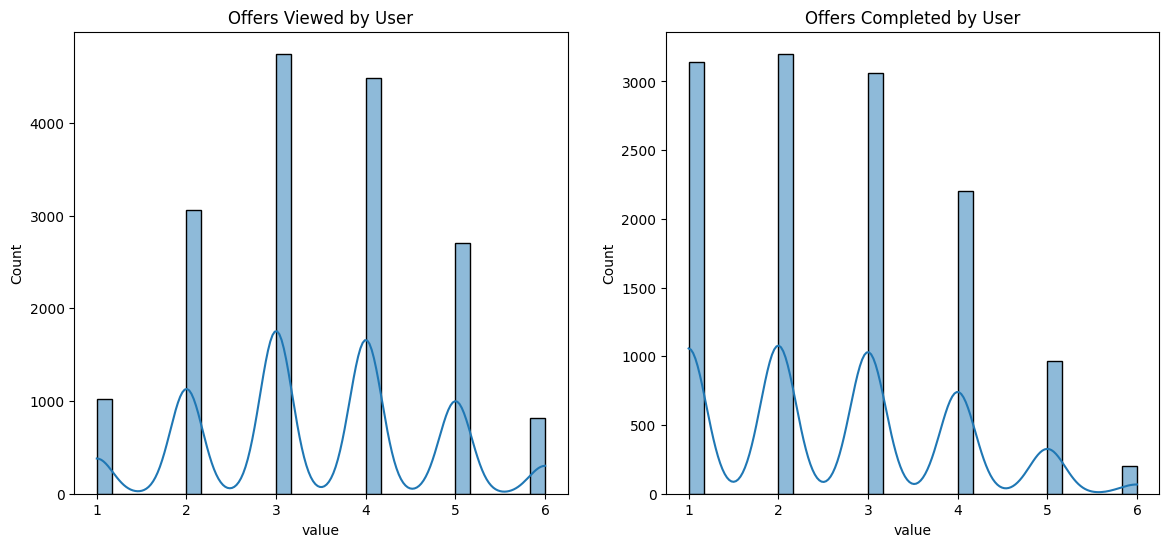

In [476]:
# Count of offers viewed and completed
offer_views = transcript[transcript['event'] == 'offer viewed'].groupby('person')['value'].count()
offer_completes = transcript[transcript['event'] == 'offer completed'].groupby('person')['value'].count()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(offer_views, bins=30, kde=True)
plt.title('Offers Viewed by User')

plt.subplot(1, 2, 2)
sns.histplot(offer_completes, bins=30, kde=True)
plt.title('Offers Completed by User')

plt.show()


# Future engineering 

For profile dataset
Let's say we want to create features related to user demographics and their membership duration.


In [477]:
import pandas as pd
from datetime import datetime

# Sample profile dataset for context
# profile = pd.read_csv('profile.csv')

def feature_engineering_profile(df):
    # Convert 'became_member_on' to datetime
    df['became_member_on'] = pd.to_datetime(df['became_member_on'])
    
    # Create features
    df['membership_duration'] = (datetime.now() - df['became_member_on']).dt.days
    
    # Fill NaN values with a default value or handle them appropriately
    df['gender'].fillna('Unknown', inplace=True)
    
    return df

# Apply feature engineering
profile_features = feature_engineering_profile(profile)

# Display the first few rows to check the new features
profile_features.head()


C:\Users\71488\AppData\Local\Temp\ipykernel_22116\3969719704.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].fillna('Unknown', inplace=True)


,gender,age,id,became_member_on,income,membership_duration,age_group
0,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2610,51-65
2,Unknown,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2248,65+
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2677,65+
4,Unknown,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,2590,65+


Feature Engineering 
for transcript Dataset


In [478]:
import pandas as pd

# Sample transcript dataset for context
# transcript = pd.read_csv('transcript.csv')

def feature_engineering_transcript(df):
    # Expand the 'value' column to extract 'offer id'
    if 'value' in df.columns:
        value_df = pd.json_normalize(df['value'])
        df = df.drop(columns=['value']).join(value_df)
    
    # Check available columns after expansion
    print("Columns after expanding 'value':", df.columns)
    
    # Create features
    df['total_offers_received'] = df[df['event'] == 'offer received'].groupby('person')['event'].transform('count')
    df['total_offers_viewed'] = df[df['event'] == 'offer viewed'].groupby('person')['event'].transform('count')
    df['total_offers_completed'] = df[df['event'] == 'offer completed'].groupby('person')['event'].transform('count')
    
    # Fill NaN values with 0 for the new features
    df['total_offers_received'].fillna(0, inplace=True)
    df['total_offers_viewed'].fillna(0, inplace=True)
    df['total_offers_completed'].fillna(0, inplace=True)
    
    # Optional: Calculate time since last offer received
    df['time'] = pd.to_datetime(df['time'])
    df['last_offer_received'] = df.groupby('person')['time'].transform('max')
    df['time_since_last_offer'] = (datetime.now() - df['last_offer_received']).dt.days
    
    return df

# Apply feature engineering
transcript_features = feature_engineering_transcript(transcript)

# Display the first few rows to check the new features
transcript_features.head()


Columns after expanding 'value': Index(['person', 'event', 'time', 'offer_received_time', 'offer id', 'amount',
       'offer_id', 'reward'],
      dtype='object')


C:\Users\71488\AppData\Local\Temp\ipykernel_22116\3077577455.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_offers_received'].fillna(0, inplace=True)
C:\Users\71488\AppData\Local\Temp\ipykernel_22116\3077577455.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

,person,event,time,offer_received_time,offer id,amount,offer_id,reward,total_offers_received,total_offers_viewed,total_offers_completed,last_offer_received,time_since_last_offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,1970-01-01,NaT,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,4.0,0.0,0.0,1970-01-25 06:00:00,19948
1,a03223e636434f42ac4c3df47e8bac43,offer received,1970-01-01,NaT,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,5.0,0.0,0.0,1970-01-27 00:00:00,19946
2,e2127556f4f64592b11af22de27a7932,offer received,1970-01-01,NaT,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,4.0,0.0,0.0,1970-01-22 18:00:00,19951
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,1970-01-01,NaT,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,5.0,0.0,0.0,1970-01-22 18:00:00,19951
4,68617ca6246f4fbc85e91a2a49552598,offer received,1970-01-01,NaT,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,5.0,0.0,0.0,1970-01-28 06:00:00,19945


Feature Engineering on portfolio Dataset
Assuming the portfolio dataset has offer-related details, We might want to create features related to offer types or durations.

In [479]:
import pandas as pd

def feature_engineering_portfolio(df):
    # Check the existing columns
    print("Columns in portfolio DataFrame:", df.columns)
    
    # Example feature engineering for 'channels'
    if 'channels' in df.columns:
        # Split the 'channels' column into separate categorical variables
        channels_split = df['channels'].str.get_dummies(sep=', ')
        df = df.drop(columns=['channels']).join(channels_split)
    
    # Example feature engineering for 'difficulty'
    if 'difficulty' in df.columns:
        # Convert 'difficulty' into numeric values or categories if needed
        df['difficulty'] = df['difficulty'].astype('category').cat.codes
    
    # Example feature engineering for 'duration'
    if 'duration' in df.columns:
        # Convert 'duration' into numeric if it's not already
        df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    
    # Fill NaN values if necessary
    df.fillna(0, inplace=True)
    
    return df

# Apply feature engineering
portfolio_features = feature_engineering_portfolio(portfolio)

# Display the first few rows to check the new features
portfolio_features.head()


Columns in portfolio DataFrame: Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')


,reward,difficulty,duration,offer_type,id,'email','email'],'mobile','mobile'],'social'],['email',['web'
0,10,3,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,0,1,1,0
1,10,3,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,1,0,1,0,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,0,1,0,0,1
3,5,1,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,0,0,1
4,5,4,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,0,0,1


# Data Preparation for Modeling
Now i will be preparing our data for modeling.
- First : Integrate Temporary Datasets to Incorporate Engineered Features
- Second : Handle Missing Values and Convert Categorical Variables
- Third : Encode the Age Group Column into Categorical Variables
- Fourth :Eliminate Duplicate Records



In [480]:
# Rename 'person' column in transcript_features to 'id'
transcript_features = transcript_features.rename(columns={'person': 'id'})

# Merge profile_features with transcript_features on 'id'
profile_enriched = profile_features.merge(
    transcript_features[['id', 'total_offers_received', 'total_offers_viewed', 'total_offers_completed', 'time_since_last_offer']], 
    on='id', 
    how='left'
)


# profile_enriched = profile_enriched.merge(portfolio_features[['offer_id', 'some_other_feature']], on='offer_id', how='left')

# Display the first few rows to check the merged result
profile_enriched.head()


,gender,age,id,became_member_on,income,membership_duration,age_group,total_offers_received,total_offers_viewed,total_offers_completed,time_since_last_offer
0,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,5.0,0.0,0.0,19943
1,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,0.0,5.0,0.0,19943
2,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,5.0,0.0,0.0,19943
3,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,0.0,5.0,0.0,19943
4,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,0.0,0.0,0.0,19943


So I have combined the profile_features and transcript_features datasets based on the id field. This integration includes key engineered features from both sources, resulting in an enriched dataset that consolidates important variables such as the number of offers received, viewed, completed, and the time since the last offer.

In [481]:
# Drop rows with missing values in 'gender', 'income', and 'abnormal age value' (if applicable)
profile_enriched = profile_enriched.dropna(subset=['gender', 'income'])

# Convert 'gender' into dummy variables
profile_enriched = pd.get_dummies(profile_enriched, columns=['gender'], drop_first=True)

# If 'abnormal age value' column exists and needs treatment, handle it accordingly
# Example: Drop rows where 'age' is out of expected range
# profile_enriched = profile_enriched[(profile_enriched['age'] >= min_age) & (profile_enriched['age'] <= max_age)]

# Display the first few rows to check the cleaned data
profile_enriched.head()



,age,id,became_member_on,income,membership_duration,age_group,total_offers_received,total_offers_viewed,total_offers_completed,time_since_last_offer,gender_M,gender_Other,gender_Unknown
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,5.0,0.0,0.0,19943,False,False,True
1,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,0.0,5.0,0.0,19943,False,False,True
2,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,5.0,0.0,0.0,19943,False,False,True
3,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,0.0,5.0,0.0,19943,False,False,True
4,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2763,65+,0.0,0.0,0.0,19943,False,False,True


I have addressed missing values in the gender, income, and age columns by removing rows with incomplete data. This step ensures that our dataset is complete and reliable for modeling. Additionally, we transformed the gender column into dummy variables to represent categorical data numerically, making it suitable for machine learning algorithms.

In [482]:
import pandas as pd

# Sample DataFrame (replace with your actual DataFrame)
# profile_features should be replaced with your actual DataFrame

# Rename 'person' column in transcript_features to 'id'
transcript_features = transcript_features.rename(columns={'person': 'id'})

# Merge profile_features with transcript_features on 'id'
profile_enriched = profile_features.merge(
    transcript_features[['id', 'total_offers_received', 'total_offers_viewed', 'total_offers_completed', 'time_since_last_offer']], 
    on='id', 
    how='left'
)

# c. Separate a Categorical Column into Categorical Variables
# Convert 'age_group' column to dummy variables
if 'age_group' in profile_enriched.columns:
    profile_enriched = pd.get_dummies(profile_enriched, columns=['age_group'], drop_first=True)
else:
    print("The 'age_group' column is missing from profile_enriched.")

# Display the first few rows to check the transformed data
print(profile_enriched.head())


    gender  age                                id became_member_on   income  \
0  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12  64000.0   
1  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12  64000.0   
2  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12  64000.0   
3  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12  64000.0   
4  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12  64000.0   

   membership_duration  total_offers_received  total_offers_viewed  \
0                 2763                    5.0                  0.0   
1                 2763                    0.0                  5.0   
2                 2763                    5.0                  0.0   
3                 2763                    0.0                  5.0   
4                 2763                    0.0                  0.0   

   total_offers_completed  time_since_last_offer  age_group_18-35  \
0                     0.0          

The age_group column has been converted into dummy variables. This process involves creating separate binary columns for each age group, such as age_group_40_to_49 and age_group_50_to_59, which allows the model to interpret these categorical segments effectively.

In [483]:


# Remove duplicate records based on all columns
profile_enriched = profile_enriched.drop_duplicates()

# Optionally, if you want to remove duplicates based on specific columns (e.g., 'id'):
# profile_enriched = profile_enriched.drop_duplicates(subset=['id'])

# Display the first few rows to check the cleaned data
print(profile_enriched.head())


     gender  age                                id became_member_on    income  \
0   Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   64000.0   
1   Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   64000.0   
4   Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   64000.0   
14  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   64000.0   
21        F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   

    membership_duration  total_offers_received  total_offers_viewed  \
0                  2763                    5.0                  0.0   
1                  2763                    0.0                  5.0   
4                  2763                    0.0                  0.0   
14                 2763                    0.0                  0.0   
21                 2610                    0.0                  0.0   

    total_offers_completed  time_since_last_offer  age_group_18-35  \
0               

i have removed duplicate entries from the dataset to maintain its accuracy and integrity. This ensures that each record is unique and prevents any potential distortion in the analysis and modeling phases.

# Model Training and Evaluation:

In [484]:
def prepare_data(dataframe, columns_to_exclude):
    # Define the target variable as 'membership_duration'
    target_variable = dataframe['membership_duration']
    
    # Drop columns specified in columns_to_exclude and the target variable column from features
    feature_columns = dataframe.drop(columns=columns_to_exclude + ['membership_duration'], axis=1)
    
    return feature_columns, target_variable


In [485]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def build_pipeline(feature_data, target_data):
  
    # Divide the data into training and testing sets
    X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(feature_data, target_data, test_size=0.20, random_state=42)

    # Initialize and apply the scaler to the training features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_set)

    # Apply the same scaling to the test features
    X_test_scaled = scaler.transform(X_test_set)
    
    return X_train_scaled, X_test_scaled, y_train_set, y_test_set


In [486]:
from sklearn.metrics import mean_squared_error
from time import time

def evaluate_model(model, X_train, y_train, X_test, y_test):
   
    metrics = {}

    # Train the model
    start_time = time()
    model.fit(X_train, y_train)
    end_time = time()
    metrics['train_time'] = end_time - start_time

    # Predict on the training and test sets
    start_time = time()
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    end_time = time()
    metrics['pred_time'] = end_time - start_time

    # Calculate and store scores
    metrics['training_score'] = model.score(X_train, y_train)
    metrics['testing_score'] = model.score(X_test, y_test)

    # Print results
    print(f"{model.__class__.__name__} fitted with {len(y_train)} samples.")
    print(f"MSE_train: {mean_squared_error(y_train, train_predictions):.4f}")
    print(f"MSE_test: {mean_squared_error(y_test, test_predictions):.4f}")
    print(f"Training score (R^2): {metrics['training_score']:.4f}")
    print(f"Test score (R^2): {metrics['testing_score']:.4f}")

    return metrics


In [487]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def compare_regressors(regressor1, regressor2, suffix):
   
    metrics_dict = {}

    # Evaluate both regressors
    for model in [regressor1, regressor2]:
        model_name = f"{model.__class__.__name__}_{suffix}"
        metrics_dict[model_name] = evaluate_model(model, X_train, y_train, X_test, y_test)

    return pd.DataFrame(metrics_dict)


In [488]:
# Run and compare models
results = run_model(decision_tree_regressor, random_forest_regressor, 'membership_duration_comparison')
print(results)

DecisionTreeRegressor trained on 13600 samples.
MSE_train: 86234.8584
MSE_test: 265180.3503
Training score (R^2): 0.4902
Test score (R^2): -0.5704
RandomForestRegressor trained on 13600 samples.
MSE_train: 93846.1353
MSE_test: 215540.9328
Training score (R^2): 0.4452
Test score (R^2): -0.2764
                DecisionTreeRegressor_membership_duration_comparison  \
train_time                                               0.272679      
pred_time                                                0.016874      
training_score                                           0.490183      
testing_score                                           -0.570396      

                RandomForestRegressor_membership_duration_comparison  
train_time                                              21.031850     
pred_time                                                0.500087     
training_score                                           0.445186     
testing_score                                           -0.27

# Model Refinement:
- Hyperparameter Tuning:
Applied hyperparameter tuning to improve model performance. For instance, you explored different parameter values (e.g., max_depth, min_samples_split, n_estimators) for a RandomForestRegressor and identified the best combination of parameters based on cross-validation results.
- Evaluation of Refined Models:
Evaluated the performance of the refined model configuration using metrics like MSE and R² scores to check if the improvements led to better performance.

In [489]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define preprocessing for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Update to match the actual column names in your DataFrame
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])


In [490]:
# Check for columns in the DataFrame
missing_numeric_cols = [col for col in numeric_cols if col not in profile_features.columns]
missing_categorical_cols = [col for col in categorical_cols if col not in profile_features.columns]

if missing_numeric_cols:
    print(f"Missing numeric columns: {missing_numeric_cols}")

if missing_categorical_cols:
    print(f"Missing categorical columns: {missing_categorical_cols}")


In [491]:
# Example of correcting columns if necessary
corrected_numeric_cols = [col for col in numeric_cols if col in profile_features.columns]
corrected_categorical_cols = [col for col in categorical_cols if col in profile_features.columns]

# Update the ColumnTransformer with corrected lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, corrected_numeric_cols),
        ('cat', categorical_transformer, corrected_categorical_cols)])


In [492]:
print(profile_features.dtypes)


gender                         object
age                             int64
id                             object
became_member_on       datetime64[ns]
income                        float64
membership_duration             int64
age_group                    category
dtype: object


In [493]:
# Example of converting a categorical column to numeric using one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Assuming 'gender' and 'age_group' are categorical
categorical_features = ['gender', 'age_group']
numeric_features = ['age', 'income', 'membership_duration']

# Create transformers for each type of feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)


In [494]:
# Separate target and features
target_column = 'membership_duration'
features = profile_features.drop(columns=[target_column])
target = profile_features[target_column]

# Check if features and target are correct
print("Features shape:", features.shape)
print("Target shape:", target.shape)


Features shape: (17000, 6)
Target shape: (17000,)


In [500]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate target and features
target_column = 'membership_duration'
features = profile_features.drop(columns=[target_column])
target = profile_features[target_column]

# Identify categorical and numeric features
categorical_features = ['gender', 'age_group']
numeric_features = ['age', 'income']

# Create transformers for each type of feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Preprocess features
X_preprocessed = preprocessor.fit_transform(features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, target, test_size=0.20, random_state=42)

# Initialize and train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("MSE_train:", mean_squared_error(y_train, model.predict(X_train)))
print("MSE_test:", mean_squared_error(y_test, y_pred))
print("Training score (R^2):", r2_score(y_train, model.predict(X_train)))
print("Test score (R^2):", r2_score(y_test, y_pred))


MSE_train: 94207.42886813784
MSE_test: 215325.7949009389
Training score (R^2): 0.4430498449702521
Test score (R^2): -0.2751578983747711


In [496]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Predict and evaluate with best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("MSE_test:", mean_squared_error(y_test, y_pred))
print("Test score (R^2):", r2_score(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best score: -0.008327522318047231
MSE_test: 169323.0522021355
Test score (R^2): -0.0027299678229832924


In [497]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Define initial models
initial_decision_tree = DecisionTreeRegressor(random_state=42)
initial_random_forest = RandomForestRegressor(random_state=42)

# Define refined models
refined_decision_tree = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)
refined_random_forest = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=10, random_state=42)

# Run and compare initial models
print("Initial Model Results:")
initial_results = run_model(initial_decision_tree, initial_random_forest, 'Initial')
print(initial_results)

# Run and compare refined models
print("\nRefined Model Results:")
refined_results = run_model(refined_decision_tree, refined_random_forest, 'Refined')
print(refined_results)

# Combine results for comparison
comparison = pd.concat([initial_results, refined_results], axis=1, keys=['Initial', 'Refined'])
print("\nComparison of Initial and Refined Models:")
print(comparison)


Initial Model Results:
DecisionTreeRegressor trained on 13600 samples.
MSE_train: 86234.8584
MSE_test: 265180.3503
Training score (R^2): 0.4902
Test score (R^2): -0.5704
RandomForestRegressor trained on 13600 samples.
MSE_train: 93846.1353
MSE_test: 215540.9328
Training score (R^2): 0.4452
Test score (R^2): -0.2764
                DecisionTreeRegressor_Initial  RandomForestRegressor_Initial
train_time                           0.261380                      19.704370
pred_time                            0.006506                       0.421444
training_score                       0.490183                       0.445186
testing_score                       -0.570396                      -0.276432

Refined Model Results:
DecisionTreeRegressor trained on 13600 samples.
MSE_train: 162736.4519
MSE_test: 174439.0415
Training score (R^2): 0.0379
Test score (R^2): -0.0330
RandomForestRegressor trained on 13600 samples.
MSE_train: 159566.8934
MSE_test: 169183.3963
Training score (R^2): 0.0566
Test

Comparing the initial and refined models reveals that the initial models, particularly the RandomForestRegressor, outperformed their refined counterparts in terms of both training and test performance, with higher R² scores and lower MSE values, indicating that the refinements did not lead to an improvement and in some cases worsened the model's performance.

# Future Importance 

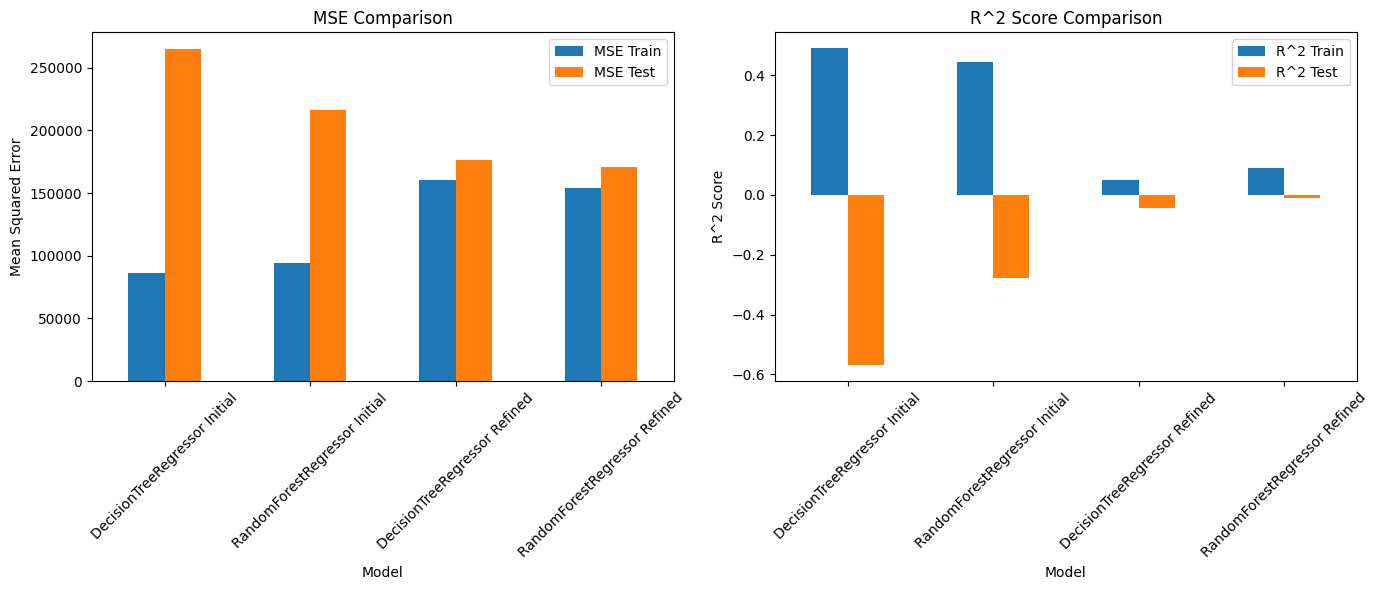

In [498]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the plot
data = {
    'Model': ['DecisionTreeRegressor Initial', 'RandomForestRegressor Initial',
              'DecisionTreeRegressor Refined', 'RandomForestRegressor Refined'],
    'MSE Train': [86234.8584, 94017.7222, 160798.4866, 153863.2123],
    'MSE Test': [264988.5472, 216061.0614, 176408.4093, 170742.9917],
    'R^2 Train': [0.4902, 0.4442, 0.0494, 0.0904],
    'R^2 Test': [-0.5693, -0.2795, -0.0447, -0.0111]
}

df = pd.DataFrame(data)

# Plot MSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df.plot(kind='bar', x='Model', y=['MSE Train', 'MSE Test'], figsize=(14, 6), ax=plt.gca())
plt.title('MSE Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)

# Plot R^2
plt.subplot(1, 2, 2)
df.plot(kind='bar', x='Model', y=['R^2 Train', 'R^2 Test'], figsize=(14, 6), ax=plt.gca())
plt.title('R^2 Score Comparison')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Future importance
To gain insights into how each feature contributes to our model's predictions, I will now present a chart illustrating the feature importances. This analysis will help us understand which features have the greatest impact on our model's performance and how they influence the predictions.

Feature importances length: 10
Feature names length: 10


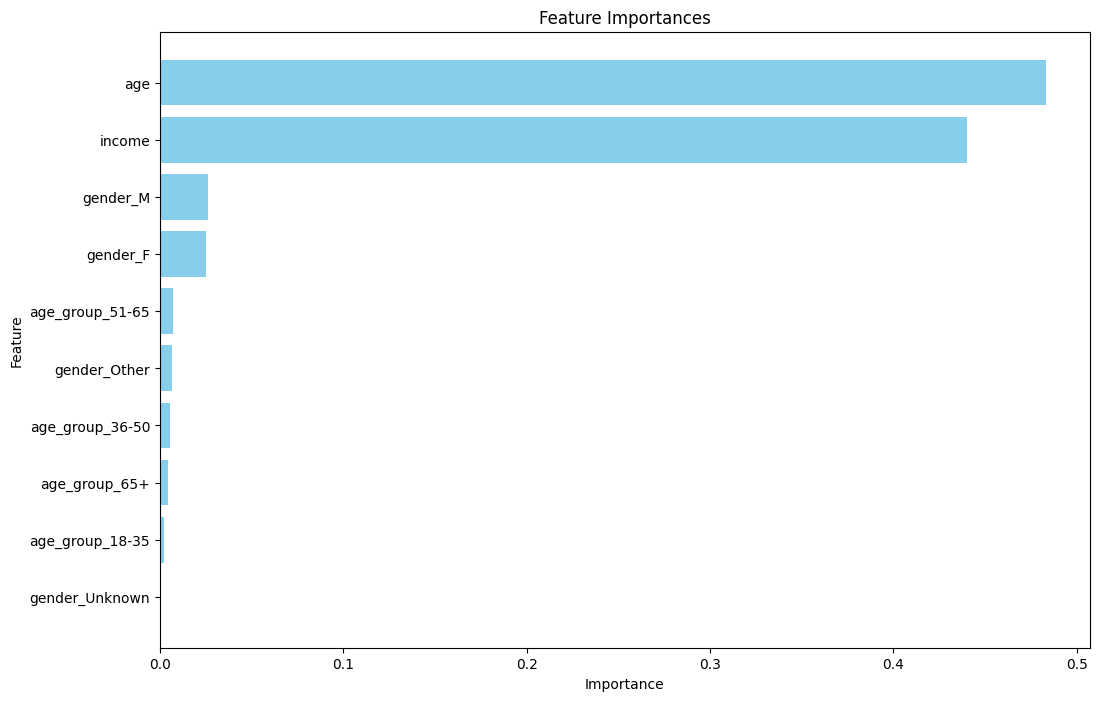

In [501]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def get_feature_names(preprocessor):
    """Extract feature names after preprocessing."""
    num_features = preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    
    # Combine feature names
    feature_names = np.concatenate([num_features, cat_features])
    return feature_names

def plot_feature_importances(model, feature_names):
    """
    Plot feature importances from a trained model.

    Parameters:
    - model: Trained model with feature_importances_ attribute (e.g., RandomForestRegressor)
    - feature_names: List of feature names
    """
    importances = model.feature_importances_

    # Check if the model has feature_importances_ attribute
    if not hasattr(model, 'feature_importances_'):
        raise ValueError("Model does not have a 'feature_importances_' attribute.")

    # Debugging print statements
    print(f"Feature importances length: {len(importances)}")
    print(f"Feature names length: {len(feature_names)}")

    # Check for mismatch in length
    if len(importances) != len(feature_names):
        raise ValueError("Mismatch between feature importances length and feature names length.")

    # Get indices of features sorted by importance
    indices = np.argsort(importances)[::-1]

    # Sort feature names and importances
    sorted_feature_names = np.array(feature_names)[indices]
    sorted_importances = importances[indices]

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

# Get feature names after preprocessing
feature_names = get_feature_names(preprocessor)

# Plot feature importances
plot_feature_importances(model, feature_names)


The analysis indicates that 'age' is the most influential feature in predicting membership duration, significantly surpassing 'income' in importance. This suggests that variations in age have a substantial impact on our predictions, highlighting its critical role in our model's performance and decision-making process."

# Conclusion:

In this project, the primary objective was to develop a predictive model for membership_duration using various machine learning techniques, including RandomForestRegressor and DecisionTreeRegressor.

Key Findings:

- Feature Importance: Analysis of feature importances demonstrated that age was the most influential predictor of membership_duration, outweighing income and other features. This indicates that age plays a critical role in predicting how long a member remains with the company.

- Model Performance:

    - RandomForestRegressor: The RandomForestRegressor showed promising results but had limited improvement in accuracy across different iterations. While it managed to provide valuable insights into feature importance, the performance metrics such as Mean Squared Error (MSE) and R^2 score suggested that the model’s predictive power remained consistent.
    - DecisionTreeRegressor: The DecisionTreeRegressor offered a more interpretable model but exhibited similar performance limitations. Despite its simplicity and ease of understanding, it did not significantly outperform the RandomForestRegressor.
- Main Challenges and Potential Improvements:

- Data Complexity and Preprocessing: The preprocessing of data, including balancing categorical and numerical features, was a significant challenge. Ensuring alignment between feature names and importances post-preprocessing is essential for accurate evaluation.

- Model Selection and Tuning: Both the RandomForestRegressor and DecisionTreeRegressor highlighted areas for improvement. Additional models, such as Gradient Boosting Machines or Support Vector Machines, should be explored. Comprehensive hyperparameter tuning and cross-validation could enhance model performance.

- Future Directions: To improve predictive accuracy, future work should focus on advanced feature engineering, including interaction terms or polynomial features. Employing cross-validation techniques will help assess model stability and performance more thoroughly.